In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from fbprophet import Prophet
from fbprophet.diagnostics import performance_metrics, cross_validation
from fbprophet.plot import plot_cross_validation_metric
import statsmodels.api as sm
import math
from math import sqrt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [0]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [0]:
rcParams['figure.figsize'] = 16, 8

In [0]:
df = pd.read_csv('Karachi 100 Historical Data.csv', sep=',', na_values='?')

In [5]:
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,"Apr 24, 2019","36,462.59","36,375.22","36,585.48","36,332.28",28.20K,0.16%
1,"Apr 23, 2019","36,404.03","36,901.24","36,911.61","36,136.11",95.42K,-1.35%
2,"Apr 22, 2019","36,901.69","37,474.80","37,479.27","36,839.29",104.28K,-1.05%
3,"Apr 19, 2019","37,292.47","36,827.08","37,729.12","36,818.16",139.07K,1.31%
4,"Apr 18, 2019","36,811.86","36,737.51","36,919.95","36,419.36",151.84K,0.16%


In [0]:
df['Date'] = pd.to_datetime(df['Date'])
df['Price'] = df['Price'].str.replace(',','')
df['Open'] = df['Open'].str.replace(',','')
df['High'] = df['High'].str.replace(',','')
df['Low'] = df['Low'].str.replace(',','')

In [0]:
df = df.drop('Vol.',1)
df = df.drop('Change %', 1)

In [0]:
df['Price'] = df['Price'].astype(float)
df['Open'] = df['Open'].astype(float)
df['High'] = df['High'].astype(float)
df['Low'] = df['Low'].astype(float)

In [0]:
df = df.drop('Open',1)
df = df.drop('High',1)
df = df.drop('Low',1)

In [10]:
df.head()
df.tail()

,Date,Price
1068,2015-01-07,32835.94
1069,2015-01-06,32668.73
1070,2015-01-05,32757.79
1071,2015-01-02,32731.61
1072,2015-01-01,32503.80


In [11]:
scaler = MinMaxScaler(feature_range=(0, 1))
df['Price'] = scaler.fit_transform(df[['Price']])
df.describe()

,Price
count,1073.000000
mean,0.449635
std,0.224856
min,0.000000
25%,0.225680
50%,0.459549
75%,0.590147
max,1.000000


In [0]:
df= df.sort_values('Date')
df = df.reset_index()
df = df.drop('index',axis=1)
df = df.set_index('Date')

In [0]:
ts = df[['Price']]
ts = ts[ts['Price'].notnull()].copy()
ts['Price'] = ts['Price'].replace(',','')
ts['Price']=ts['Price'].astype(float)
ts.describe()
ts= ts.resample('B').mean()
ts.dropna(inplace=True)

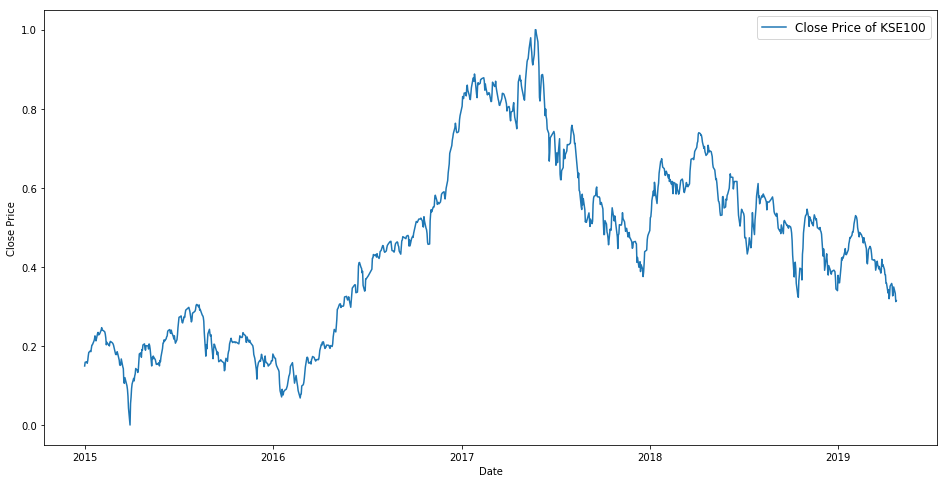

In [14]:
fig, ax = plt.subplots()
ax.plot(ts,label='Close Price of KSE100')
ax.legend(fontsize=12)
ax.xaxis.set_major_locator(mdates.YearLocator())
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

In [0]:
ts.describe()
scaler = MinMaxScaler(feature_range=(0, 1))
ts['Price'] = scaler.fit_transform(ts[['Price']])

In [16]:
df.describe()

,Price
count,1073.000000
mean,0.449635
std,0.224856
min,0.000000
25%,0.225680
50%,0.459549
75%,0.590147
max,1.000000


In [0]:
trainX = df[:805]
testX = df[805:]

In [0]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [0]:
look_back = 1
trainX, trainY = create_dataset(trainX.values, look_back)
testX, testY = create_dataset(testX.values, look_back)

In [20]:
df.tail()

,Price
Date,
2019-04-18,0.329228
2019-04-19,0.349296
2019-04-22,0.332979
2019-04-23,0.312199
2019-04-24,0.314644


In [0]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
trainY = np.reshape(trainY, (trainY.shape[0], 1, 1))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
testY = np.reshape(testY, (testY.shape[0], 1, 1))

In [22]:
model = Sequential()
model.add(LSTM(units=50,return_sequences = True,input_shape=(1,1)))
model.add(Dropout(0.5))
model.add(Dense(units=1))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])

In [24]:
history = model.fit(trainX, trainY, epochs = 100, batch_size = 32,validation_split=0.33)
testPredict = model.predict(testX)

Instructions for updating:
Use tf.cast instead.


Train on 538 samples, validate on 265 samples
Epoch 1/100
538/538 [==============================] - 1s 1ms/step - loss: 0.1389 - acc: 0.0019 - val_loss: 0.3688 - val_acc: 0.0000e+00
Epoch 2/100
538/538 [==============================] - 0s 91us/step - loss: 0.0992 - acc: 0.0019 - val_loss: 0.2767 - val_acc: 0.0000e+00
Epoch 3/100
538/538 [==============================] - 0s 85us/step - loss: 0.0695 - acc: 0.0019 - val_loss: 0.1972 - val_acc: 0.0000e+00
Epoch 4/100
538/538 [==============================] - 0s 86us/step - loss: 0.0463 - acc: 0.0019 - val_loss: 0.1354 - val_acc: 0.0000e+00
Epoch 5/100
538/538 [==============================] - 0s 87us/step - loss: 0.0334 - acc: 0.0019 - val_loss: 0.0920 - val_acc: 0.0000e+00
Epoch 6/100
538/538 [==============================] - 0s 95us/step - loss: 0.0282 - acc: 0.0019 - val_loss: 0.0680 - val_acc: 0.0038
Epoch 7/100
538/538 [==============================] - 0s 88us/step - loss: 0.0265 - acc: 0.0019 - val_loss: 0.0573 - val_acc: 0.00

In [25]:
print(history.history['loss'])
print(history.history['acc'])
print(history.history['val_loss'])
print(history.history['val_acc'])

[0.1389230760887653, 0.09921100378368868, 0.06951444676374414, 0.04632475160643957, 0.03341019972050943, 0.028184849159535865, 0.026490553867307295, 0.024207520752203508, 0.02309796146937684, 0.021909883038095827, 0.01949156554187319, 0.016552839282775456, 0.015521028577644364, 0.01402924803248347, 0.012858861676489997, 0.009506652730631341, 0.009477715807721073, 0.008689749490843609, 0.006654892002533581, 0.007049138901831381, 0.005233556345506782, 0.0050995833565893, 0.0038415683220490316, 0.004192770820554193, 0.0035186107530082024, 0.004352348932795586, 0.00421684945770799, 0.003598536390267645, 0.004143489081564889, 0.0038828256022406665, 0.0034297786170069725, 0.00347246094277911, 0.0038327063212247364, 0.0036764412055477554, 0.0031854260131218178, 0.002932127606691481, 0.0030364464833418457, 0.0033097767329958293, 0.0035795574578487742, 0.003371313446267165, 0.0035867252972212422, 0.0029299928457043427, 0.0030322381014828343, 0.0033865784377995257, 0.0030086950548720236, 0.00329

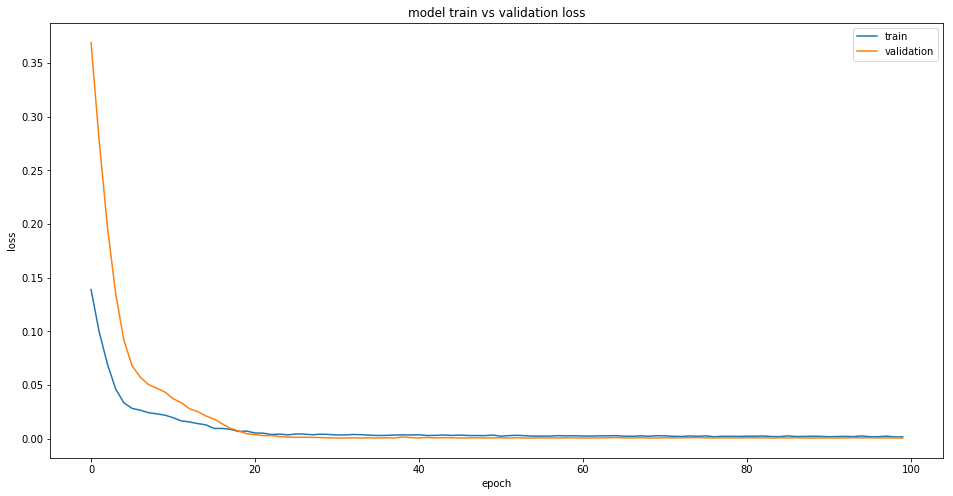

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [0]:
testforrmse = np.array(testPredict).reshape(-1, 1)
predforrmse = np.array(testX).reshape(-1, 1)
rmse_lstm = sqrt(mean_squared_error(testforrmse, predforrmse))

In [0]:
trainPredict = model.predict(trainX)

trainPredict = scaler.inverse_transform(np.array(trainPredict).reshape(-1, 1))
df['Price'] = scaler.inverse_transform(df[['Price']])
testPredict = scaler.inverse_transform(np.array(testPredict).reshape(-1, 1))
testX = scaler.inverse_transform(np.array(testX).reshape(-1, 1))

In [29]:
trainScore = math.sqrt(mean_squared_error(trainY[:,0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[:,0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.02 RMSE
Test Score: 0.02 RMSE


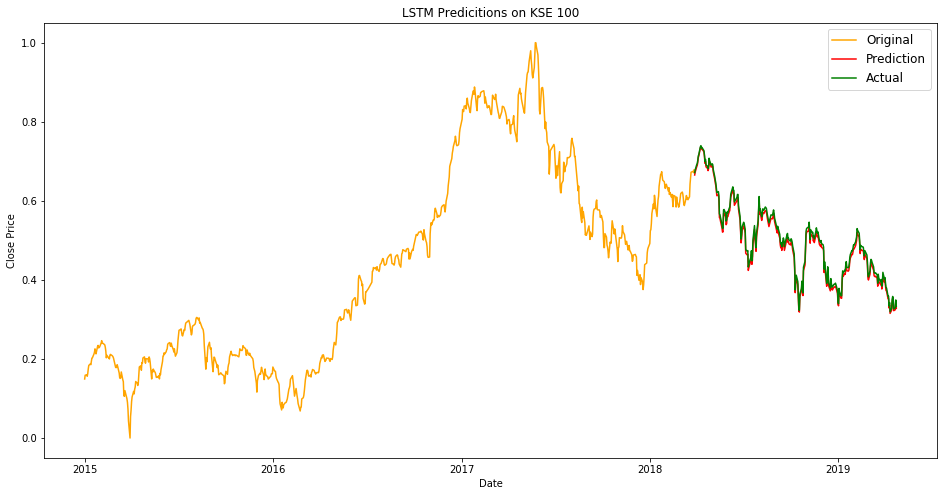

In [30]:
fig2, ax2 = plt.subplots()
ax2.plot(df.index[:807],df['Price'][:807],label='Original',color='orange')
ax2.plot(df.index[807:],testPredict,label='Prediction',color='red')
ax2.plot(df.index[807:],testX,label='Actual',color='green')
ax2.xaxis.set_major_locator(mdates.YearLocator())
ax2.legend(fontsize=12)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title("LSTM Predicitions on KSE 100")
plt.show()